# Graph Kolmogorov-Arnold Network (GKAN) Implementation with PyTorch Geometric

## About Graph Kolmogorov-Arnold Network (GKAN)
The Graph Kolmogorov-Arnold Network (GKAN) is a novel architecture that integrates the principles of the Kolmogorov-Arnold representation theorem into the design of graph neural networks. This theorem states that any multivariate continuous function can be represented as a finite sum of continuous functions of one variable and addition. By incorporating this concept, GKAN aims to improve the learning and representation of complex patterns in graph-structured data. The key components of GKAN include Fourier transforms and attention mechanisms, which help in capturing both local and global graph structures effectively.


## Library Imports
First, we import the necessary libraries for deep learning, mathematical operations, and graph-based computations.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import gc

- **Torch and Torch NN**: Core PyTorch libraries for building and training neural networks.
- **Numpy**: Library for numerical operations.
- **Random**: Python library for generating random numbers.
- **Garbage Collector (gc)**: Python library to help manage memory.
- **PyTorch Geometric**: Libraries for graph-based deep learning, including transformations and dataset utilities.

In [8]:
import torch_geometric.transforms as T
from torch_geometric.utils import *
from torch_geometric.datasets import Planetoid

## GKAN Class
Defines the overall GKAN model, consisting of multiple `NaiveFourierKANLayer` layers.

In [9]:
class GKAN(torch.nn.Module):
    def __init__(self, in_feat, hidden_feat, out_feat, grid_feat, num_layers, use_bias=False):
        super().__init__()
        self.num_layers = num_layers
        self.lin_in = nn.Linear(in_feat, hidden_feat, bias=use_bias)
        self.lins = torch.nn.ModuleList()
        for i in range(num_layers):
            self.lins.append(NaiveFourierKANLayer(hidden_feat, hidden_feat, grid_feat, addbias=use_bias))
        self.lins.append(nn.Linear(hidden_feat, out_feat, bias=False))

    def forward(self, x, adj):
        x = self.lin_in(x)
        for layer in self.lins[:self.num_layers - 1]:
            x = layer(spmm(adj, x))
        x = self.lins[-1](x)
        return x.log_softmax(dim=-1)


### Initialization Parameters:
- **in_feat**: Number of input features.
- **hidden_feat**: Number of hidden features in the intermediate layers.
- **out_feat**: Number of output features (number of classes for classification).
- **grid_feat**: Size of the frequency grid for the Fourier transform.
- **num_layers**: Number of layers in the GKAN.
- **use_bias**: Boolean to decide whether to add a bias term.

### Input Linear Layer:
A linear transformation layer to process the input features.

### NaiveFourierKAN Layers:
A list of `NaiveFourierKANLayer` layers for the hidden transformations.

### Output Linear Layer:
A final linear layer to produce the output logits.

## NaiveFourierKANLayer Class
Defines a single layer of the GKAN using Fourier transform-based kernel attention.

In [10]:
class NaiveFourierKANLayer(nn.Module):
    def __init__(self, inputdim, outdim, gridsize=300, addbias=True):
        super(NaiveFourierKANLayer, self).__init__()
        self.gridsize = gridsize
        self.addbias = addbias
        self.inputdim = inputdim
        self.outdim = outdim

        self.fouriercoeffs = nn.Parameter(torch.randn(2, outdim, inputdim, gridsize) /
                                          (np.sqrt(inputdim) * np.sqrt(self.gridsize)))
        if self.addbias:
            self.bias = nn.Parameter(torch.zeros(1, outdim))


### Initialization Parameters:
- **inputdim**: Number of input features.
- **outdim**: Number of output features.
- **gridsize**: Size of the frequency grid for the Fourier transform.
- **addbias**: Boolean to decide whether to add a bias term.

### Fourier Coefficients:
Initialized as a trainable parameter, representing the weights for the cosine and sine transformations. These coefficients are scaled by the square root of the input dimension and grid size for normalization.

### Bias Term:
Initialized as a trainable parameter if `addbias` is `True`.


### Reshape Input:
The input tensor `x` is reshaped to a 2D tensor for consistent processing.

### Frequency Grid:
A grid of frequencies `k` is created, ranging from 1 to the grid size.

### Cosine and Sine Transformations:
The reshaped input `xrshp` is used to compute the cosine and sine transformations to find patterns in the input data, resulting in two tensors `c` and `s` representing the Fourier features of the input.

### Concatenate and Reshape:
These tensors are then concatenated and reshaped to match the dimensions required for the `torch.einsum` function.

### Einsum Operation:
Computes the dot product between the concatenated Fourier features and the Fourier coefficients.

### Bias Addition:
Adds the bias term if applicable.

### Output Reshape:
Reshapes the output tensor to match the desired output shape.

In [11]:
def forward(self, x):
        xshp = x.shape
        outshape = xshp[0:-1] + (self.outdim,)
        x = x.view(-1, self.inputdim)
        k = torch.reshape(torch.arange(1, self.gridsize + 1, device=x.device), (1, 1, 1, self.gridsize))
        xrshp = x.view(x.shape[0], 1, x.shape[1], 1)
        c = torch.cos(k * xrshp)
        s = torch.sin(k * xrshp)
        c = torch.reshape(c, (1, x.shape[0], x.shape[1], self.gridsize))
        s = torch.reshape(s, (1, x.shape[0], x.shape[1], self.gridsize))
        y = torch.einsum("dbik,djik->bj", torch.concat([c, s], axis=0), self.fouriercoeffs)
        if self.addbias:
            y += self.bias
        y = y.view(outshape)
        return y

### Reshape Input:
The input tensor `x` is reshaped to a 2D tensor for consistent processing.

### Frequency Grid:
A grid of frequencies `k` is created, ranging from 1 to the grid size.

### Cosine and Sine Transformations:
The reshaped input `xrshp` is used to compute the cosine and sine transformations to find patterns in the input data, resulting in two tensors `c` and `s` representing the Fourier features of the input.

### Concatenate and Reshape:
These tensors `c` and `s` are then concatenated and reshaped to match the dimensions required for the `torch.einsum` function.

### Einsum Operation:
Computes the dot product between the concatenated Fourier features and the Fourier coefficients.

### Bias Addition:
If applicable, adds the bias term.

### Output Reshape:
Reshapes the output tensor to match the desired output shape.

In [12]:
def train(args, feat, adj, label, mask, model, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(feat, adj)
    pred, true = out[mask], label[mask]
    loss = F.nll_loss(pred, true)
    acc = int((pred.argmax(dim=-1) == true).sum()) / int(mask.sum())
    loss.backward()
    optimizer.step()
    return acc, loss.item()

In [13]:

@torch.no_grad()
def eval(args, feat, adj, model):
    model.eval()
    with torch.no_grad():
        pred = model(feat, adj)
    pred = pred.argmax(dim=-1)
    return pred

class args:
    path = './data/'
    name = 'Cora'
    logger_path = 'logger/esm'
    dropout = 0.0
    hidden_size = 256
    grid_size = 200
    n_layers = 2
    epochs = 1000
    early_stopping = 100
    seed = 42
    lr = 5e-4
def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.bool, device=index.device)
    mask[index] = 1
    return mask

def random_disassortative_splits(labels, num_classes, trn_percent=0.6, val_percent=0.2):
    labels, num_classes = labels.cpu(), num_classes.cpu().numpy()
    indices = []
    for i in range(num_classes):
        index = torch.nonzero((labels == i)).view(-1)
        index = index[torch.randperm(index.size(0))]
        indices.append(index)

    percls_trn = int(round(trn_percent * (labels.size()[0] / num_classes)))
    val_lb = int(round(val_percent * labels.size()[0]))
    train_index = torch.cat([i[:percls_trn] for i in indices], dim=0)

    rest_index = torch.cat([i[percls_trn:] for i in indices], dim=0)
    rest_index = rest_index[torch.randperm(rest_index.size(0))]

    train_mask = index_to_mask(train_index, size=labels.size()[0])
    val_mask = index_to_mask(rest_index[:val_lb], size=labels.size()[0])
    test_mask = index_to_mask(rest_index[val_lb:], size=labels.size()[0])

    return train_mask, val_mask, test_mask

In [14]:
args()

args.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)

transform = T.Compose([T.NormalizeFeatures(), T.GCNNorm(), T.ToSparseTensor()])

torch.cuda.empty_cache()
gc.collect()



dataset = Planetoid(args.path, args.name, transform=transform)[0]

Processing...
Done!
c:\Users\Admin\OneDrive\Desktop\ML\ML\Lib\site-packages\torch_geometric\utils\sparse.py:268: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ..\aten\src\ATen\SparseCsrTensorImpl.cpp:55.)
  adj = torch.sparse_csr_tensor(


In [ ]:
in_feat = dataset.num_features
out_feat = max(dataset.y) + 1

model = KanGNN(
    in_feat=in_feat,
    hidden_feat=args.hidden_size,
    out_feat=out_feat,
    grid_feat=args.grid_size,
    num_layers=args.n_layers,
    use_bias=False,
).to(args.device)

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

adj = dataset.adj_t.to(args.device)
feat = dataset.x.float().to(args.device)
label = dataset.y.to(args.device)

trn_mask, val_mask, tst_mask = random_disassortative_splits(label, out_feat)
trn_mask, val_mask, tst_mask = trn_mask.to(args.device), val_mask.to(args.device), tst_mask.to(args.device)
torch.cuda.empty_cache()
gc.collect()
for epoch in range(args.epochs):
    trn_acc, trn_loss = train(args, feat, adj, label, trn_mask, model, optimizer)
    pred = eval(args, feat, adj, model)
    val_acc = int((pred[val_mask] == label[val_mask]).sum()) / int(val_mask.sum())
    tst_acc = int((pred[tst_mask] == label[tst_mask]).sum()) / int(tst_mask.sum())

    print(f'Epoch: {epoch:04d}, Trn_loss: {trn_loss:.4f}, Trn_acc: {trn_acc:.4f}, Val_acc: {val_acc:.4f}, Test_acc: {tst_acc:.4f}')

My PC doesn't have CUDA, so the code was run on Kaggle.

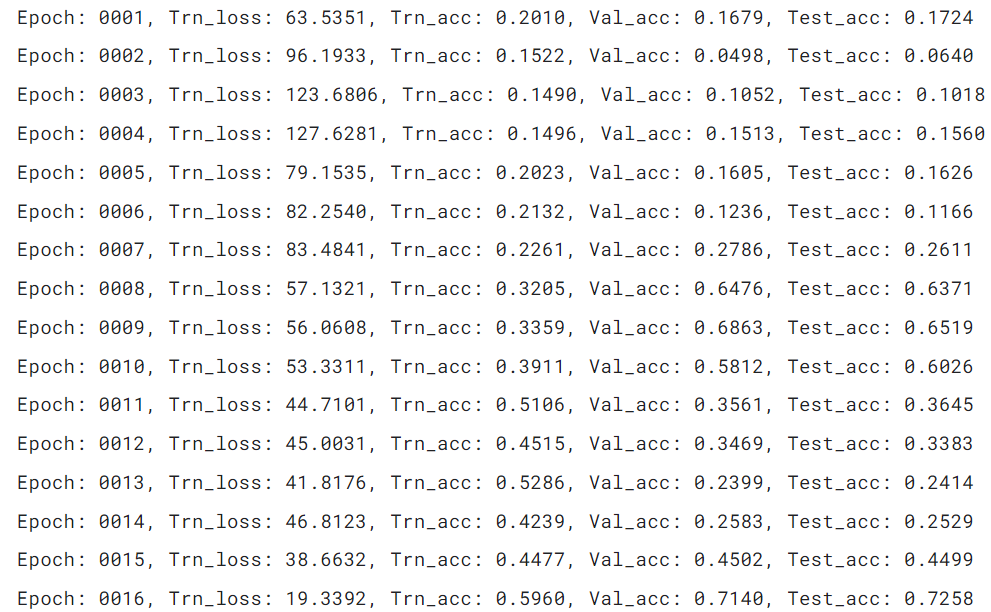
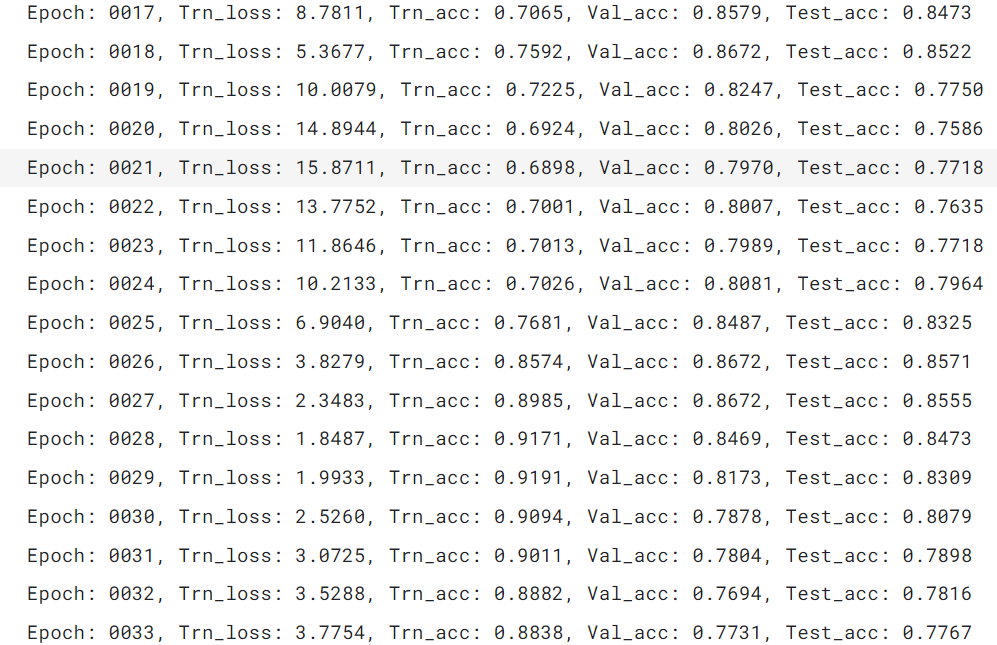
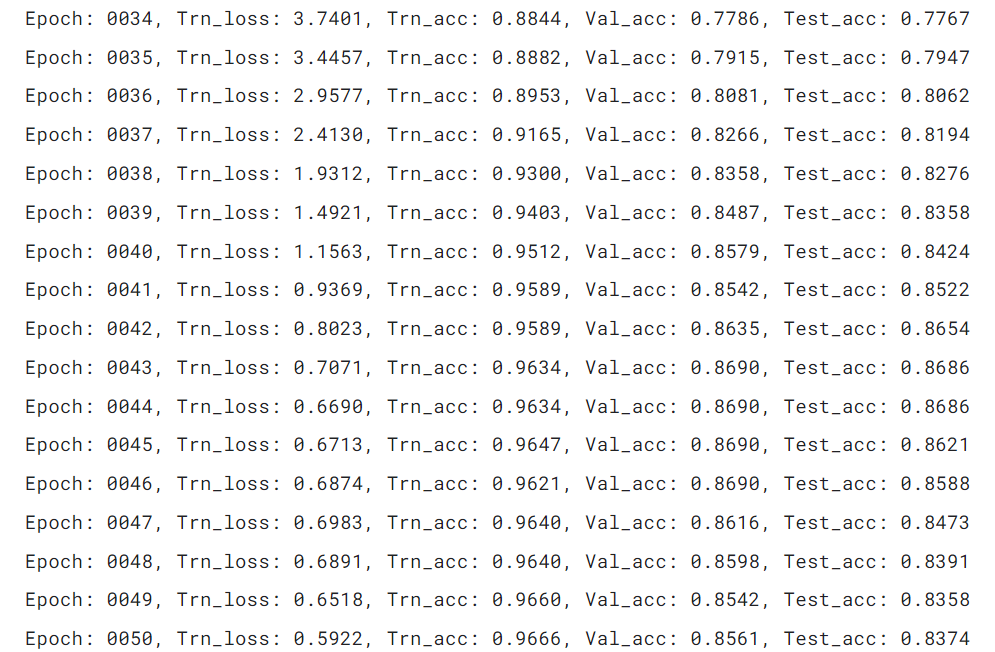